In [1]:
#Habilitar si usas google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Lectura de la data

In [3]:
# Utilizando google colab ruta Jesus
#data = pd.read_csv('/content/drive/MyDrive/IA/PracticaCalificada2-CC421/train.csv', chunksize=42000000)
# Utilizando google colab ruta Franz
#data = pd.read_csv('/content/drive/MyDrive/IA_PC2/train.csv', chunksize=1000000 , index_col=0)
# Utilizando google colab ruta Abel
data = pd.read_csv('/content/drive/MyDrive/IA_PC2/train.csv', chunksize=1000000 , index_col=0)
# Utilizando google colab ruta Eros
#data = pd.read_csv('/content/drive/MyDrive/IA-PC2/train.csv', chunksize=1000000 , index_col=0)
# Desde local (jupyter notebook)
#data = pd.read_csv('train.csv', chunksize=42000000)

In [4]:
data.get_chunk()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,,
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
2014-09-13 21:44:38.0000001,7.0,2014-09-13 21:44:38 UTC,-73.976676,40.785630,-73.959196,40.775114,1
2010-09-20 14:50:37.0000002,7.3,2010-09-20 14:50:37 UTC,-73.992103,40.671385,-73.992103,40.671385,2
2013-04-26 14:03:00.000000118,10.5,2013-04-26 14:03:00 UTC,-73.978423,40.751135,-73.993397,40.762197,5


In [5]:
df = data.get_chunk() 

In [6]:
print(df.head())

                               fare_amount  ... passenger_count
key                                         ...                
2010-03-06 21:13:04.0000003           10.1  ...               1
2010-03-10 16:19:00.000000128          3.7  ...               1
2014-02-27 08:50:19.0000006           11.0  ...               1
2011-02-11 17:46:17.0000005            7.3  ...               3
2011-07-25 12:48:00.00000074           6.9  ...               1

[5 rows x 7 columns]


# Preprocesamiento de la data

Se cuentan las filas con valores nulos, como estás representan una cantidad infíma
simplemente se eliminarán

In [7]:
print(df.isnull().sum())

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    4
dropoff_latitude     4
passenger_count      0
dtype: int64


In [8]:
df.dropna(inplace = True)
print(df.isnull().sum())

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [9]:
df.drop(df[df['fare_amount']<0].index, inplace=True)

Se utilizará solo la hora del tiempo de recogo, para ello lo extraemos en otra columna

In [10]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [11]:
df['pickup_hour'] =df['pickup_datetime'].dt.hour

In [12]:
print(df['pickup_hour'])

key
2010-03-06 21:13:04.0000003      21
2010-03-10 16:19:00.000000128    16
2014-02-27 08:50:19.0000006       8
2011-02-11 17:46:17.0000005      17
2011-07-25 12:48:00.00000074     12
                                 ..
2014-11-17 13:51:02.0000002      13
2013-02-25 17:51:28.0000004      17
2013-07-12 22:03:41.0000006      22
2009-01-17 09:35:37.0000002       9
2010-01-16 15:46:00.000000153    15
Name: pickup_hour, Length: 999957, dtype: int64


En la columna de números de pasajeros los valores están entre 0-6, existen pocos valores mayores a 7, asi que para no
eliminarlos todos los valores mayores a 7 serán considerados como 7

In [13]:
print(df['passenger_count'].value_counts())

1    691822
2    147770
5     70894
3     43886
4     21224
6     20806
0      3554
9         1
Name: passenger_count, dtype: int64


In [14]:
df.drop(df[df["passenger_count"] >=7].index, inplace=True)

In [15]:
print(df['passenger_count'].value_counts())

1    691822
2    147770
5     70894
3     43886
4     21224
6     20806
0      3554
Name: passenger_count, dtype: int64


In [16]:
print(df.dtypes)
print(df.head())

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
pickup_hour                   int64
dtype: object
                               fare_amount  ... pickup_hour
key                                         ...            
2010-03-06 21:13:04.0000003           10.1  ...          21
2010-03-10 16:19:00.000000128          3.7  ...          16
2014-02-27 08:50:19.0000006           11.0  ...           8
2011-02-11 17:46:17.0000005            7.3  ...          17
2011-07-25 12:48:00.00000074           6.9  ...          12

[5 rows x 8 columns]


In [17]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour
key,,,,,,,,
2010-03-06 21:13:04.0000003,10.1,2010-03-06 21:13:04,-73.993113,40.755552,-73.969351,40.797908,1,21
2010-03-10 16:19:00.000000128,3.7,2010-03-10 16:19:00,-73.948102,40.770608,-73.952923,40.768025,1,16
2014-02-27 08:50:19.0000006,11.0,2014-02-27 08:50:19,-73.977236,40.743045,-73.997854,40.719837,1,8
2011-02-11 17:46:17.0000005,7.3,2011-02-11 17:46:17,-73.954060,39.603285,-73.977015,40.776712,3,17
2011-07-25 12:48:00.00000074,6.9,2011-07-25 12:48:00,-73.978575,40.753067,-73.964632,40.764258,1,12


###Creando columna de distancia recorrida

Hallaremos la distancia recorrida en km para cada fila. \\
Usamos la Haversine formula, que halla la distancia entre dos puntos en una esfera dadas sus longitudes y latitudes. \\
$d = 2r \arcsin (\sqrt{\sin^{2}(\frac{\varphi_2 - \varphi_1}{2}) + \cos(\varphi_1)cos(\varphi_2)\sin^{2}(\frac{\lambda_2 - \lambda_1}{2})})$ \\
Sea $\varphi_1, \varphi_2$ latitudes y $\lambda_1, \lambda_2$ longitudes \\
referencia: https://en.wikipedia.org/wiki/Haversine_formula

Para disminuir los cálculos, lo llevaremos a ángulo doble: $\sin^{2}(\frac{\varphi_2 - \varphi_1}{2}) = \frac{1-\cos(\varphi_2 - \varphi_1)}{2}$

In [18]:
from math import cos, asin, sqrt, pi
p = pi/180
radioTierra = 6371
df["distancia_recorrida"] = df.apply(
    lambda fila: 2*radioTierra * asin(sqrt(0.5 - cos((fila.dropoff_latitude - fila.pickup_latitude) * p)/2 + cos(fila.pickup_latitude * p) * cos(fila.dropoff_latitude * p) * (1 - cos((fila.dropoff_longitude - fila.pickup_longitude) * p)) / 2)) 
, axis=1)

In [19]:
df.head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,distancia_recorrida
key,,,,,,,,,
2010-03-06 21:13:04.0000003,10.1,2010-03-06 21:13:04,-73.993113,40.755552,-73.969351,40.797908,1,21,5.117160
2010-03-10 16:19:00.000000128,3.7,2010-03-10 16:19:00,-73.948102,40.770608,-73.952923,40.768025,1,16,0.497314
2014-02-27 08:50:19.0000006,11.0,2014-02-27 08:50:19,-73.977236,40.743045,-73.997854,40.719837,1,8,3.110906
2011-02-11 17:46:17.0000005,7.3,2011-02-11 17:46:17,-73.954060,39.603285,-73.977015,40.776712,3,17,130.493625
2011-07-25 12:48:00.00000074,6.9,2011-07-25 12:48:00,-73.978575,40.753067,-73.964632,40.764258,1,12,1.711032
2014-07-23 10:16:44.0000001,20.5,2014-07-23 10:16:44,-73.997789,40.741463,-73.984134,40.780437,1,10,4.483717
2015-03-27 20:55:48.0000003,16.5,2015-03-27 20:55:48,-73.938957,40.821960,-73.954590,40.768120,1,20,6.129730
2009-03-04 19:38:00.000000250,5.7,2009-03-04 19:38:00,-73.978618,40.777623,-73.987258,40.764442,1,19,1.636317
2014-01-13 16:42:00.000000119,21.5,2014-01-13 16:42:00,-73.972545,40.790757,-73.989142,40.740922,1,16,5.714965


Eliminamos valores raros, donde la distancia no va acorde con la tarifa

In [20]:
import numpy as np
##Se crea una nueva columna con valores "ok" y "no"
df["booleano"]= np.where((df["distancia_recorrida"]>100)& (df["fare_amount"]<20),'no','ok')


In [21]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,distancia_recorrida,booleano
key,,,,,,,,,,
2010-03-06 21:13:04.0000003,10.1,2010-03-06 21:13:04,-73.993113,40.755552,-73.969351,40.797908,1,21,5.117160,ok
2010-03-10 16:19:00.000000128,3.7,2010-03-10 16:19:00,-73.948102,40.770608,-73.952923,40.768025,1,16,0.497314,ok
2014-02-27 08:50:19.0000006,11.0,2014-02-27 08:50:19,-73.977236,40.743045,-73.997854,40.719837,1,8,3.110906,ok
2011-02-11 17:46:17.0000005,7.3,2011-02-11 17:46:17,-73.954060,39.603285,-73.977015,40.776712,3,17,130.493625,no
2011-07-25 12:48:00.00000074,6.9,2011-07-25 12:48:00,-73.978575,40.753067,-73.964632,40.764258,1,12,1.711032,ok
...,...,...,...,...,...,...,...,...,...,...
2014-11-17 13:51:02.0000002,4.0,2014-11-17 13:51:02,-73.950787,40.770836,-73.951043,40.774543,1,13,0.412763,ok
2013-02-25 17:51:28.0000004,7.0,2013-02-25 17:51:28,-73.983035,40.748276,-73.974725,40.741978,1,17,0.990211,ok
2013-07-12 22:03:41.0000006,10.5,2013-07-12 22:03:41,-74.003482,40.743577,-73.976758,40.765265,1,22,3.298915,ok


In [22]:
#eliminamos todas las filas que tengan "no"
indices = df[df['booleano']=='no'].index
df.drop(indices, inplace=True)

In [23]:
#eliminamos la columna booleano
df.drop(columns=["booleano"], inplace=True)
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,distancia_recorrida
key,,,,,,,,,
2010-03-06 21:13:04.0000003,10.1,2010-03-06 21:13:04,-73.993113,40.755552,-73.969351,40.797908,1,21,5.117160
2010-03-10 16:19:00.000000128,3.7,2010-03-10 16:19:00,-73.948102,40.770608,-73.952923,40.768025,1,16,0.497314
2014-02-27 08:50:19.0000006,11.0,2014-02-27 08:50:19,-73.977236,40.743045,-73.997854,40.719837,1,8,3.110906
2011-07-25 12:48:00.00000074,6.9,2011-07-25 12:48:00,-73.978575,40.753067,-73.964632,40.764258,1,12,1.711032
2014-07-23 10:16:44.0000001,20.5,2014-07-23 10:16:44,-73.997789,40.741463,-73.984134,40.780437,1,10,4.483717
...,...,...,...,...,...,...,...,...,...
2014-11-17 13:51:02.0000002,4.0,2014-11-17 13:51:02,-73.950787,40.770836,-73.951043,40.774543,1,13,0.412763
2013-02-25 17:51:28.0000004,7.0,2013-02-25 17:51:28,-73.983035,40.748276,-73.974725,40.741978,1,17,0.990211
2013-07-12 22:03:41.0000006,10.5,2013-07-12 22:03:41,-74.003482,40.743577,-73.976758,40.765265,1,22,3.298915


#Usando algoritmos y entrenando

Se usarán las siguientes carácteristicas


In [24]:
X = df[['passenger_count','pickup_hour','distancia_recorrida']]
y = df.fare_amount
print(X)

                               passenger_count  ...  distancia_recorrida
key                                             ...                     
2010-03-06 21:13:04.0000003                  1  ...             5.117160
2010-03-10 16:19:00.000000128                1  ...             0.497314
2014-02-27 08:50:19.0000006                  1  ...             3.110906
2011-07-25 12:48:00.00000074                 1  ...             1.711032
2014-07-23 10:16:44.0000001                  1  ...             4.483717
...                                        ...  ...                  ...
2014-11-17 13:51:02.0000002                  1  ...             0.412763
2013-02-25 17:51:28.0000004                  1  ...             0.990211
2013-07-12 22:03:41.0000006                  1  ...             3.298915
2009-01-17 09:35:37.0000002                  3  ...             5.119378
2010-01-16 15:46:00.000000153                2  ...             5.705464

[998119 rows x 3 columns]


In [25]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler(quantile_range = (0.1,0.9)).fit(X)
X = transformer.transform(X)

In [26]:
print(X)

[[ 0.          7.          3.00472573]
 [ 0.          2.         -1.61512036]
 [ 0.         -6.          0.99847153]
 ...
 [ 0.          8.          1.18648023]
 [ 2.         -5.          3.00694362]
 [ 1.          1.          3.59302896]]


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [28]:
from sklearn.tree import DecisionTreeRegressor
regressor1 = DecisionTreeRegressor(random_state=0)
regressor2 = DecisionTreeRegressor(random_state=0, max_depth=13,
                                   max_features='auto',
                                   splitter='best')

a1 = regressor1.fit(X_train,y_train)
a2 = regressor2.fit(X_train,y_train)

y1=a1.predict(X_test)
y2=a2.predict(X_test)

In [29]:
print(regressor1)
print()
print(regressor2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')


In [30]:
print("Costo de viaje de los datos de prueba")
print(y_test)
print()

print("Predicciones de costos de viaje")
print("Primer modelo")
print(y1)
print("Segundo modelo")
print(y2)

Costo de viaje de los datos de prueba
key
2013-12-13 10:37:38.0000005       7.00
2013-12-26 17:22:00.00000076     52.00
2015-03-28 22:57:12.0000004       4.50
2012-02-08 20:41:00.00000060      8.90
2009-02-01 18:07:34.0000002      72.15
                                 ...  
2012-11-07 23:24:00.00000018     21.00
2013-11-19 13:07:17.0000002       6.50
2014-07-11 12:51:00.000000126     5.00
2013-03-10 21:17:00.000000121     5.50
2014-05-19 19:36:04.0000003      32.83
Name: fare_amount, Length: 299436, dtype: float64

Predicciones de costos de viaje
Primer modelo
[ 5.3 50.5  5.4 ...  7.3  3.7 24.5]
Segundo modelo
[ 6.88585523 53.58271186  4.83481006 ...  7.40623441  4.83481006
 27.46566667]


#Graficas de las predicciones de precios

In [31]:
import matplotlib.pyplot as plt

#Grafica de la primera prediccion

> 



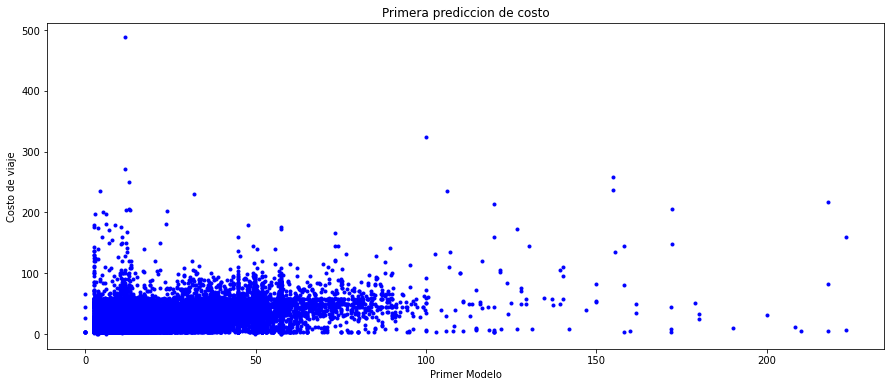

In [33]:
plt.figure(figsize=(15,6))

x_1 = y1 
y_1 = y_test


plt.scatter(x_1 , y_1 , marker='.', color='b')
plt.xlabel("Primer Modelo")
plt.ylabel("Costo de viaje")
plt.title("Primera prediccion de costo")
plt.show()

##Grafica de la segunda prediccion

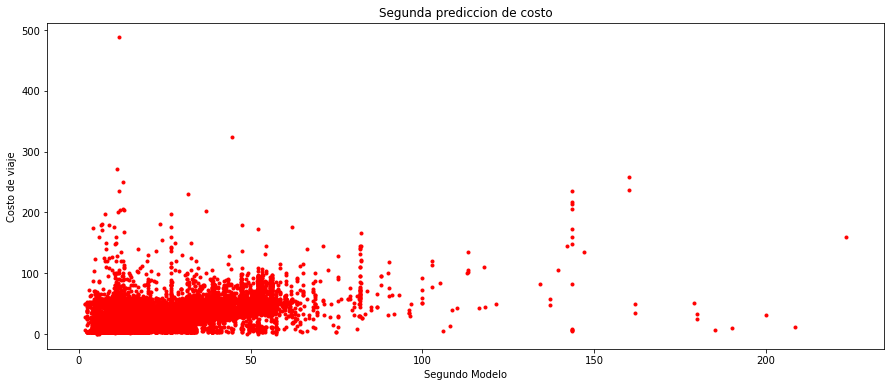

In [34]:
plt.figure(figsize=(15,6))

x_2 = y2 
y_2 = y_test

plt.scatter(x_2 , y_2 , marker='.', color='r')
plt.xlabel("Segundo Modelo")
plt.ylabel("Costo de viaje")
plt.title("Segunda prediccion de costo")
plt.show()

#Comparación

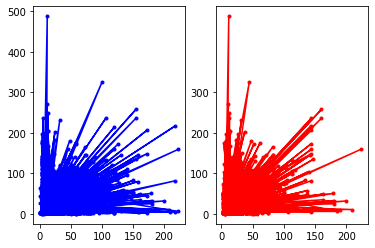

In [35]:
fig, ax = plt.subplots(1,2)

ax[0].plot(x_1 ,y_1 , marker='.' ,color ='b')
plt.yticks([0,100,200,300])

ax[1].plot(x_2 ,y_2 , marker='.',color ='r')
plt.yticks([0,100,200,300])
plt.show()


# Metricas del modelo

**Error absoluto medio (MAE)** 

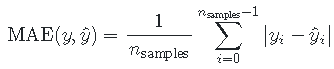

In [36]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y1))
print(mean_absolute_error(y_test, y2))

3.359555160552545
2.4608551487065657


**Error cuadrático medio**

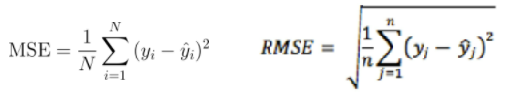

In [37]:
from sklearn.metrics import mean_squared_error

#MSE
print("MSE")
print(mean_squared_error(y_test, y1))
print(mean_squared_error(y_test, y2))

print()

#RMSE
print("RMSE")
print(mean_squared_error(y_test, y1,squared=False))
print(mean_squared_error(y_test, y2,squared=False))


MSE
46.40643035437358
29.086932652047604

RMSE
6.812226534281841
5.3932302613598475


**Error máximo**

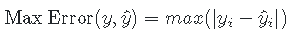

In [38]:
from sklearn.metrics import max_error

print(max_error(y_test, y1))
print(max_error(y_test, y2))

476.3
476.28333333333336


**Error absoluto mediano**

ErrorAbsolutoMediano.png

In [39]:
from sklearn.metrics import median_absolute_error

print(median_absolute_error(y_test, y1))
print(median_absolute_error(y_test, y2))

1.9000000000000004
1.3945594855305021


**Puntuación de varianza explicada**

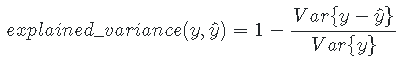

In [40]:
from sklearn.metrics import explained_variance_score

print(explained_variance_score(y_test, y1))
print(explained_variance_score(y_test, y2))

0.5277016926370077
0.7039686585490812


**Puntuación R²**

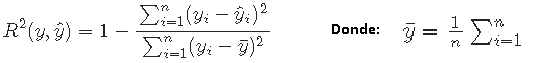

In [41]:
from sklearn.metrics import r2_score

print(r2_score(y_test, y1))
print(r2_score(y_test, y2))

0.5276990323814629
0.7039680421072813


**Error porcentual absoluto medio**

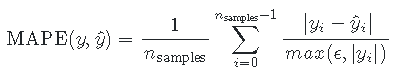

**Desviación media de Tweedie**

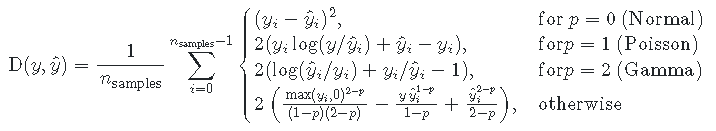

OBS: Para la desviación media de Poisson y Gamma, la variable de prueba y la de predicción deben tener elementos extrictamente positivos.